In [1]:
# compare the performance gain from tuning compared with choosing NN vs. boosted trees

In [1]:
import pandas as pd
tuned_agg_df = pd.read_csv("./results/tuned_aggregated_results_non_tabpfn_with_default.csv")


In [2]:
tuned_agg_df.head()

,Unnamed: 0,alg_name,dataset_name,Accuracy__test_median,Accuracy__test_mean,time__train_median,time__train_mean,Accuracy__test_mean_min,Accuracy__test_mean_max,normalized_Accuracy__test_mean,Accuracy_rank_mean,normalized_F1__test_mean,F1_rank_mean,F1__test_mean_min,F1__test_mean_max,normalized_Log Loss__test_mean,Log Loss_rank_mean,Log Loss__test_mean_min,Log Loss__test_mean_max
0,0,CatBoost,openml__APSFailure__168868,0.994145,0.994013,6.412328,7.276401,0.970303,0.994500,0.979880,3.0,0.979880,3.0,0.970303,0.994500,0.002121,3.0,0.017652,0.624879
1,1,CatBoost,openml__Amazon_employee_access__34539,0.946903,0.947359,1.708439,1.729567,0.928927,0.952150,0.793690,5.0,0.793690,5.0,0.928927,0.952150,0.000847,2.0,0.155615,1.020650
2,2,CatBoost,openml__Australian__146818,0.869565,0.872464,1.347650,1.393643,0.601449,0.872464,1.000000,1.0,1.000000,1.0,0.601449,0.872464,0.000000,1.0,0.302677,1.682198
3,3,CatBoost,openml__Bioresponse__9910,0.798940,0.795521,5.815126,6.748842,0.727272,0.796848,0.980938,2.0,0.980938,2.0,0.727272,0.796848,0.008506,4.0,0.451718,0.967133
4,4,CatBoost,openml__Census-Income__168340,0.958869,0.958658,830.825629,857.921920,0.943238,0.958658,1.000000,1.0,1.000000,1.0,0.943238,0.958658,0.000866,2.0,0.109108,0.474823


In [3]:
# categorize each alg

neural_algs = [
    "MLP",
    "TabNet",
    "VIME",
    "TabTransformer",
    "NODE",
    "STG",
    "NAM",
    "DeepFM",
    "SAINT",
    "DANet",
    "rtdl_MLP",
    "rtdl_ResNet",
    "rtdl_FTTransformer",
]

tree_algs = [
    "LightGBM",
    "XGBoost",
    "CatBoost"
]

tuned_agg_df.loc[:, "alg_type"] = "baseline"
tuned_agg_df.loc[tuned_agg_df["alg_name"].isin(neural_algs), "alg_type"] = "neural"
tuned_agg_df.loc[tuned_agg_df["alg_name"].isin(tree_algs), "alg_type"] = "trees"


In [4]:
# get the best performance for each alg type for each dataset

import numpy as np

dataset_list = tuned_agg_df["dataset_name"].unique()

nn_tree_diff = {}

for metric in ["Accuracy", "Log Loss", "F1"]:
    nn_tree_diff[metric] = []
    grouped_tuned = tuned_agg_df.groupby(["alg_type", "dataset_name"])[f"normalized_{metric}__test_mean"].agg(["max", "min"]).reset_index()
    for dataset in dataset_list:
        if metric == "Log Loss":
            get_col = "min"
        else:
            get_col = "max"

        tree_metric = grouped_tuned[(grouped_tuned["alg_type"] == "trees") & (grouped_tuned["dataset_name"] == dataset)][get_col].values
        nn_metric = grouped_tuned[(grouped_tuned["alg_type"] == "neural") & (grouped_tuned["dataset_name"] == dataset)][get_col].values

        if len(tree_metric) == 1 & len(nn_metric) == 1:
            nn_tree_diff[metric].append(nn_metric[0] - tree_metric[0])
        else:
            print(f"could not get result for dataset {dataset}")
            nn_tree_diff[metric].append(np.nan)


In [5]:
# for each dataset and each alg, (and each metric) get the difference in metric between the tuned alg and the default hparams

catboost_ll_metric_diff = {}
xgb_ll_metric_diff = {}
rtdl_resnet_ll_metric_diff = {}
saint_ll_metric_diff = {}

for metric in ["Accuracy", "Log Loss", "F1"]:
    catboost_ll_metric_diff[metric] = []
    xgb_ll_metric_diff[metric] = []
    rtdl_resnet_ll_metric_diff[metric] = []
    saint_ll_metric_diff[metric] = []

    for dataset in dataset_list:
        df = tuned_agg_df.loc[tuned_agg_df["dataset_name"] == dataset, :]
        # get the impact of tuning for catboost
        c_untuned = df.loc[df["alg_name"] == "CatBoost_default", f"normalized_{metric}__test_mean"].values
        c_tuned = df.loc[df["alg_name"] == "CatBoost", f"normalized_{metric}__test_mean"].values
        if len(c_untuned) == 1 & len(c_tuned) == 1:
            catboost_ll_metric_diff[metric].append(c_tuned[0] - c_untuned[0])
        else:
            print(f"no result for CatBoost for dataset {dataset}...")
            catboost_ll_metric_diff[metric].append(np.nan)

        # get the impact of tuning for xgb
        x_untuned = df.loc[df["alg_name"] == "XGBoost_default", f"normalized_{metric}__test_mean"].values
        x_tuned = df.loc[df["alg_name"] == "XGBoost", f"normalized_{metric}__test_mean"].values
        if len(x_untuned) == 1 & len(x_tuned) == 1:
            xgb_ll_metric_diff[metric].append(x_tuned[0] - x_untuned[0])
        else:
            print(f"no result for XGB for dataset {dataset}...")
            xgb_ll_metric_diff[metric].append(np.nan)


        # get the difference of tuning for rtdl-ResNet
        r_untuned = df.loc[df["alg_name"] == "rtdl_ResNet_default", f"normalized_{metric}__test_mean"].values
        r_tuned = df.loc[df["alg_name"] == "rtdl_ResNet", f"normalized_{metric}__test_mean"].values
        if len(r_untuned) == 1 & len(r_tuned) == 1:
            rtdl_resnet_ll_metric_diff[metric].append(r_tuned[0] - r_untuned[0])
        else:
            print(f"no result for rtdl_resnet for dataset {dataset}...")
            rtdl_resnet_ll_metric_diff[metric].append(np.nan)

        # get the difference of tuning for saint
        s_untuned = df.loc[df["alg_name"] == "SAINT_default", f"normalized_{metric}__test_mean"].values
        s_tuned = df.loc[df["alg_name"] == "SAINT", f"normalized_{metric}__test_mean"].values
        if len(s_untuned) == 1 & len(s_tuned) == 1:
            saint_ll_metric_diff[metric].append(s_tuned[0] - s_untuned[0])
        else:
            print(f"no result for saint for dataset {dataset}...")
            saint_ll_metric_diff[metric].append(np.nan)


    # catboost_ll_metric_diff = 
# tuned_agg_df.groupby(["dataset_name", "alg_name"])["normalized_Log Loss__test_mean"]

no result for saint for dataset openml__APSFailure__168868...
no result for saint for dataset openml__Australian__146818...
no result for saint for dataset openml__Bioresponse__9910...
no result for saint for dataset openml__Census-Income__168340...
no result for saint for dataset openml__Fashion-MNIST__146825...
no result for saint for dataset openml__GesturePhaseSegmentationProcessed__14969...
no result for saint for dataset openml__Internet-Advertisements__167125...
no result for saint for dataset openml__MiniBooNE__168335...
no result for saint for dataset openml__PhishingWebsites__14952...
no result for saint for dataset openml__Satellite__167211...
no result for saint for dataset openml__ada_agnostic__3896...
no result for saint for dataset openml__airlines__189354...
no result for saint for dataset openml__anneal__2867...
no result for saint for dataset openml__bank-marketing__9899...
no result for saint for dataset openml__cardiotocography__9979...
no result for saint for datas

In [6]:
# here are the two sets of values we will plot
print("difference for tuning (catboost) | difference from tuning (resnet) | difference between NN and trees")
for i, dataset in enumerate(dataset_list):
    print(f"{dataset:40s} : {catboost_ll_metric_diff[metric][i]:.3f} | {rtdl_resnet_ll_metric_diff[metric][i]:.3f} | {nn_tree_diff[metric][i]:.3f}")

difference for tuning (catboost) | difference from tuning (resnet) | difference between NN and trees
openml__APSFailure__168868               : 0.058 | 0.034 | -0.074
openml__Amazon_employee_access__34539    : 0.058 | 0.095 | -0.076
openml__Australian__146818               : 0.027 | 0.016 | -0.037
openml__Bioresponse__9910                : 0.180 | 0.268 | -0.264
openml__Census-Income__168340            : 0.032 | 0.018 | -0.270
openml__Click_prediction_small__190408   : 0.000 | 0.000 | -0.016
openml__Fashion-MNIST__146825            : 0.037 | -0.000 | -0.006
openml__GesturePhaseSegmentationProcessed__14969 : 0.139 | 0.073 | -0.216
openml__Internet-Advertisements__167125  : 0.017 | 0.950 | 0.014
openml__JapaneseVowels__3510             : 0.009 | 0.003 | 0.004
openml__LED-display-domain-7digit__125921 : 0.072 | -0.043 | 0.023
openml__MagicTelescope__3954             : 0.000 | 0.016 | -0.003
openml__MiceProtein__146800              : 0.045 | 0.007 | 0.021
openml__MiniBooNE__168335         

number where Accuracy diff between nn and trees is larger than tuning CatBoost:
96 (of 163, or 58.90%)


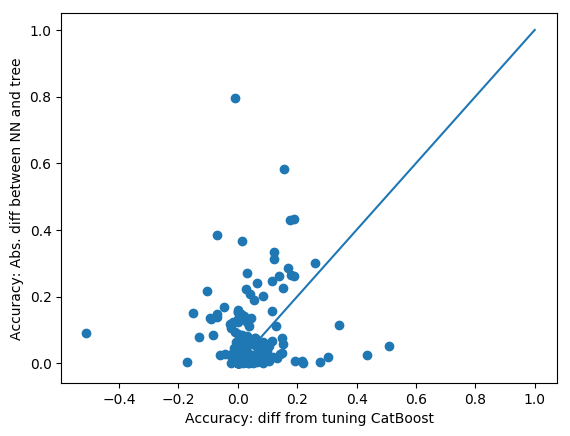

In [61]:
# now plot these two... 
import matplotlib.pyplot as plt

# df = rtdl_resnet_ll_metric_diff
# alg_name = "ResNet"

# df = saint_ll_metric_diff
# alg_name = "SAINT"


df = catboost_ll_metric_diff
alg_name = "CatBoost"

# metric = "Log Loss"
metric = "Accuracy"

non_nan = ~np.isnan(np.array(df[metric]) - np.array(nn_tree_diff[metric]))

tuning_data = np.array(df[metric])[non_nan]
nn_tree_data = np.abs(nn_tree_diff[metric])[non_nan]
plt.scatter(tuning_data, nn_tree_data)
# plt.scatter(rtdl_resnet_ll_metric_diff[metric], np.abs(nn_tree_diff[metric]))
plt.plot([0, 1], [0, 1])
plt.xlabel(f"{metric}: diff from tuning {alg_name}")
plt.ylabel(f"{metric}: Abs. diff between NN and tree")

num_tree_diff_larger = np.sum(nn_tree_data > tuning_data)
print(f"number where {metric} diff between nn and trees is larger than tuning {alg_name}:")
print(f"{num_tree_diff_larger} (of {len(nn_tree_data)}, or {100. * num_tree_diff_larger / len(nn_tree_data):.2f}%)")

In [60]:
# # np.sum()
# num_tune_larger = np.sum(np.array(df[metric])[non_nan] >= np.array(nn_tree_diff[metric])[non_nan])
# num_nn_tree_larger = np.sum(np.array(df[metric])[non_nan] < np.array(nn_tree_diff[metric])[non_nan])
# print("num datasets where tuning has larger diff:")
# print(f"{100 * float(num_tune_larger) / (num_tune_larger + num_nn_tree_larger):.2f} ({num_tune_larger} of {num_tune_larger + num_nn_tree_larger})")
# print("num where tree-vs-nn is larger diff:")
# print(f"{100 * float(num_nn_tree_larger) / (num_tune_larger + num_nn_tree_larger):.2f} ({num_nn_tree_larger} of {num_tune_larger + num_nn_tree_larger})")

